In [63]:
import numpy as np
import matplotlib.pyplot as plt
import wandb
from tqdm import tqdm

api = wandb.Api()
ENT = "TomFrederik"
PROJ = "MT-ToyTask-Ours"
JOB_ID = "9728972" #NOTE <-- change this for new runs

def gen_run_id_list(job_id):
    my_list = []
    for setting_num in range(21):
        for seed_num in range(3):
            my_list.append(f"setting_{setting_num}_seed_{seed_num}_job_{job_id}")
    return my_list

def fetch_last_loss(run_id: str, loss_name: str = "tuning_loss") -> float:
    run = api.run(f"{ENT}/{PROJ}/{run_id}")
    return run.history(keys=[f'Validation/{loss_name}']).iloc[-1][f'Validation/{loss_name}']


def fetch_loss_list_per_setting(job_id, loss_name: str = "tuning_loss"):
    out_dict = dict()
    for setting_num in tqdm(range(21)):
        loss_list = []
        for seed_num in range(3):
            run_id = f"setting_{setting_num}_seed_{seed_num}_job_{job_id}"
            loss = fetch_last_loss(run_id, loss_name)
            loss_list.append(loss)
        out_dict[setting_num] = loss_list
    return out_dict

def compute_mean_std_per_setting(loss_dict):
    out_dict = dict()
    for key, val in loss_dict.items():
        mean = np.mean(val)
        std = np.std(val, ddof=1)
        out_dict[key] = (mean, std)
    return out_dict

In [64]:
# run id lists per setting
no_05 = [2, 4, 6]
yes_05 = [0, 1, 3, 5]
no_075 = [9, 11, 13]
yes_075 = [7, 8, 10, 12]
no_1 = [16, 18, 20]
yes_1 = [14, 15, 17, 19]

In [65]:
mean_std_per_setting = compute_mean_std_per_setting(fetch_loss_list_per_setting(JOB_ID))

100%|██████████| 21/21 [00:19<00:00,  1.06it/s]


In [66]:
print(mean_std_per_setting)

{0: (0.5038341879844666, 0.057810257538056006), 1: (0.5135832826296488, 0.053474350480905056), 2: (0.5757095118363699, 0.07676697680438467), 3: (0.5192529062430064, 0.04300479611655347), 4: (0.6427499850591024, 0.030130048657121523), 5: (0.5125447312990824, 0.011806963803415197), 6: (0.521559456984202, 0.010177588438005898), 7: (0.8920036753018697, 0.2249489879084201), 8: (0.8910880287488302, 0.21573774020579647), 9: (0.7736607591311137, 0.07275890687624564), 10: (0.8774821360905966, 0.19885802641350914), 11: (0.7454430262247721, 0.10604462257253434), 12: (0.7665027181307474, 0.1095672856241135), 13: (0.6908064484596252, 0.13883580211593377), 14: (1.050689955552419, 0.16221699385889662), 15: (1.0455237825711567, 0.16258572960253495), 16: (1.2080293496449788, 0.2552943941942726), 17: (1.0242211023966472, 0.16108991111036944), 18: (0.9454437692960104, 0.2082934460316862), 19: (0.8815164764722189, 0.15681137738669973), 20: (0.8032146493593851, 0.15226391393256172)}


In [67]:
test_only_true_view_05 = [mean_std_per_setting[key] for key in yes_05]
test_only_true_view_075 = [mean_std_per_setting[key] for key in yes_075]
test_only_true_view_1 = [mean_std_per_setting[key] for key in yes_1]

test_only_false_view_05 = [mean_std_per_setting[key] for key in no_05]
test_only_false_view_075 = [mean_std_per_setting[key] for key in no_075]
test_only_false_view_1 = [mean_std_per_setting[key] for key in no_1]

In [68]:
print(test_only_true_view_05)

[(0.5038341879844666, 0.057810257538056006), (0.5135832826296488, 0.053474350480905056), (0.5192529062430064, 0.04300479611655347), (0.5125447312990824, 0.011806963803415197)]


In [69]:
xticks_yes = np.array([0, 0.1, 0.2, 0.5])
xticks_no = np.array([0.1, 0.2, 0.5])
plot_kwargs = dict(width=0.025, capsize=4)

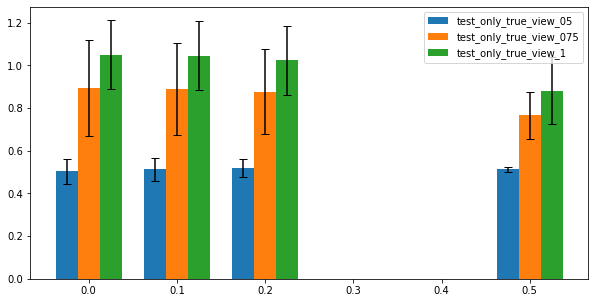

In [70]:
# eval for test_only true
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(xticks_yes-0.025, [x[0] for x in test_only_true_view_05], yerr=[x[1] for x in test_only_true_view_05], label="test_only_true_view_05", **plot_kwargs)
ax.bar(xticks_yes, [x[0] for x in test_only_true_view_075], yerr=[x[1] for x in test_only_true_view_075], label="test_only_true_view_075", **plot_kwargs)
ax.bar(xticks_yes+0.025, [x[0] for x in test_only_true_view_1], yerr=[x[1] for x in test_only_true_view_1], label="test_only_true_view_1", **plot_kwargs)
plt.legend()

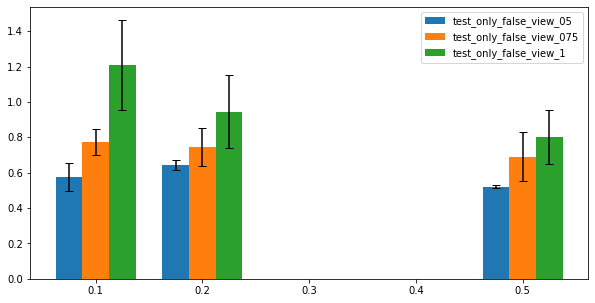

In [71]:
# eval for test_only false
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(xticks_no-0.025, [x[0] for x in test_only_false_view_05], yerr=[x[1] for x in test_only_false_view_05], label="test_only_false_view_05", **plot_kwargs)
ax.bar(xticks_no, [x[0] for x in test_only_false_view_075], yerr=[x[1] for x in test_only_false_view_075], label="test_only_false_view_075", **plot_kwargs)
ax.bar(xticks_no+0.025, [x[0] for x in test_only_false_view_1], yerr=[x[1] for x in test_only_false_view_1], label="test_only_false_view_1", **plot_kwargs)
plt.legend()